In [1]:
%config InlineBackend.figure_formats = ['svg']
import sys
sys.path.insert(1, '../')

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math
from os import path

from deployment_instance import ExperimentResult
from src.ingest_data import ingest_experiment_results
from src.query_data import get_data_exfiltration_times, percent_of_data_exfiltrated
from statistics import mean
import seaborn as sns

from lifelines import KaplanMeierFitter
import pandas as pd

In [2]:
# Baseline attacker
baseline_standalone_d0_h50 = ingest_experiment_results(path.join('data/Layered/EquifaxSmall/baseline_standalone_d0_h50'))
baseline_standalone_d2_h0 = ingest_experiment_results(path.join('data/Layered/EquifaxSmall/baseline_standalone_d2_h0'))
baseline_layered_d2_h50 = ingest_experiment_results(path.join('data/Layered/EquifaxSmall/baseline_layered_d2_h50'))

# DFS attacker
dfs_standalone_d0_h50 = ingest_experiment_results(path.join('data/Layered/EquifaxSmall/dfs_standalone_d0_h50'))
dfs_standalone_d2_h0 = ingest_experiment_results(path.join('data/Layered/EquifaxSmall/dfs_standalone_d2_h0'))
dfs_layered_d2_h50 = ingest_experiment_results(path.join('data/Layered/EquifaxSmall/dfs_layered_d2_h50'))

# BFS attacker
bfs_standalone_d0_h50 = ingest_experiment_results(path.join('data/Layered/EquifaxSmall/bfs_standalone_d0_h50'))
bfs_standalone_d2_h0 = ingest_experiment_results(path.join('data/Layered/EquifaxSmall/bfs_standalone_d2_h0'))
bfs_layered_d2_h50 = ingest_experiment_results(path.join('data/Layered/EquifaxSmall/bfs_layered_d2_h50'))

In [3]:
baseline_layered_d2_h50_times = get_data_exfiltration_times(baseline_layered_d2_h50, expected_files=12)
baseline_standalone_d0_h50_times = get_data_exfiltration_times(baseline_standalone_d0_h50, expected_files=12)
baseline_standalone_d2_h0_times = get_data_exfiltration_times(baseline_standalone_d2_h0, expected_files=12)

dfs_layered_d2_h50_times = get_data_exfiltration_times(dfs_layered_d2_h50, expected_files=12)
dfs_standalone_d0_h50_times = get_data_exfiltration_times(dfs_standalone_d0_h50, expected_files=12)
dfs_standalone_d2_h0_times = get_data_exfiltration_times(dfs_standalone_d2_h0, expected_files=12)

bfs_layered_d2_h50_times = get_data_exfiltration_times(bfs_layered_d2_h50, expected_files=12)
bfs_standalone_d0_h50_times = get_data_exfiltration_times(bfs_standalone_d0_h50, expected_files=12)
bfs_standalone_d2_h0_times = get_data_exfiltration_times(bfs_standalone_d2_h0, expected_files=12)

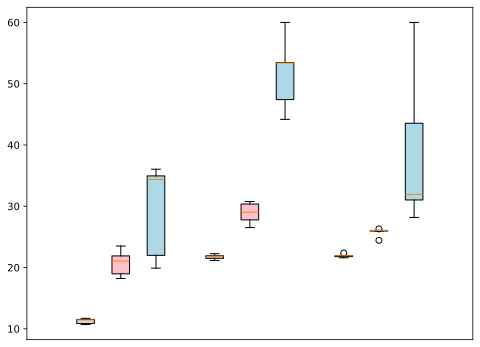

In [4]:
# Box plot comparing data exfiltration times
positions = [.3, .6, .9, 1.2, 1.5, 2.2]


baseline_data = [baseline_standalone_d2_h0_times['time_exfiltrated'], baseline_standalone_d0_h50_times['time_exfiltrated'], baseline_layered_d2_h50_times['time_exfiltrated']]
dfs_data = [dfs_standalone_d2_h0_times['time_exfiltrated'], dfs_standalone_d0_h50_times['time_exfiltrated'], dfs_layered_d2_h50_times['time_exfiltrated']]
bfs_data = [bfs_standalone_d2_h0_times['time_exfiltrated'], bfs_standalone_d0_h50_times['time_exfiltrated'], bfs_layered_d2_h50_times['time_exfiltrated']]

all_data = baseline_data + dfs_data + bfs_data

baseline_positions = [.3, .6, .9]
dfs_positions = [1.3, 1.6, 1.9]
bfs_positions = [2.3, 2.6, 2.9]
positions = [.3, .6, .9, 1.4, 1.7, 2.0, 2.5, 2.8, 3.1]

plt.figure(figsize=(8, 6))
boxplot = plt.boxplot(all_data, positions=positions, patch_artist=True, widths=0.15)

plt.xticks([])
# hide xticks
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=True)

plt.ylabel('')
plt.xlabel('')
plt.title('')

# fill with colors
colors = ['lightgrey', 'pink', 'lightblue', 'lightgrey', 'pink', 'lightblue', 'lightgrey', 'pink', 'lightblue']
for patch, color in zip(boxplot['boxes'], colors):
    patch.set_facecolor(color)

# Output as svg
plt.savefig('./plots/adaptive_times.svg', transparent=True)

In [5]:
colors = ['tab:grey', 'tab:pink', 'tab:blue']

def plot_survival(df_list, ax, x_axis_low=0, x_axis_high=60):
    color_idx = 0

    for df in df_list:
        # Fit the Kaplan-Meier estimator
        kmf = KaplanMeierFitter()
        kmf.fit(df['time_exfiltrated'], df['survival'])
        
        # Using Seaborn for a more customized plot
        ax.step(kmf.survival_function_.index, kmf.survival_function_["KM_estimate"], where="post", color=colors[color_idx])
        color_idx += 1

    # set range of x-axis to 0-60
    ax.set_xlim(x_axis_low, x_axis_high)
    # ax.title('Survival Function')
    # ax.xlabel('Time')
    # ax.ylabel('Survival Probability')

    kmf.survival_function_["KM_estimate"]

def plot_ecdf(df_list, ax, x_axis_low=0, x_axis_high=60):
    color_idx = 0

    for df in df_list:
        snsPlot = sns.ecdfplot(data=df['time_exfiltrated'], ax=ax)
        snsPlot.set(xlim=(x_axis_low, x_axis_high))
        # Remoev title, x-axis label, and y-axis label
        snsPlot.set_title('')
        snsPlot.set_xlabel('')
        snsPlot.set_ylabel('')

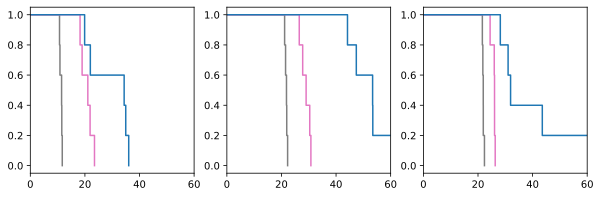

In [6]:
fig, axs = plt.subplots(figsize=(10, 3), ncols=3)
plot_survival([baseline_standalone_d2_h0_times, baseline_standalone_d0_h50_times, baseline_layered_d2_h50_times], axs[0])
plot_survival([dfs_standalone_d2_h0_times, dfs_standalone_d0_h50_times, dfs_layered_d2_h50_times], axs[1])
plot_survival([bfs_standalone_d2_h0_times, bfs_standalone_d0_h50_times, bfs_layered_d2_h50_times], axs[2])
fig.savefig('./plots/layered_survival_equiSmall.svg', transparent=True)

In [7]:
# Baseline attacker
baseline_standalone_d0_h50 = ingest_experiment_results(path.join('data/Layered/EquifaxLarge/baseline_standalone_d0_h50'))
baseline_standalone_d2_h0 = ingest_experiment_results(path.join('data/Layered/EquifaxLarge/baseline_standalone_d2_h0'))
baseline_layered_d2_h50 = ingest_experiment_results(path.join('data/Layered/EquifaxLarge/baseline_layered_d2_h50'))

# DFS attacker
dfs_standalone_d0_h50 = ingest_experiment_results(path.join('data/Layered/EquifaxLarge/dfs_standalone_d0_h50'))
dfs_standalone_d2_h0 = ingest_experiment_results(path.join('data/Layered/EquifaxLarge/dfs_standalone_d2_h0'))
dfs_layered_d2_h50 = ingest_experiment_results(path.join('data/Layered/EquifaxLarge/dfs_layered_d2_h50'))

# BFS attacker
bfs_standalone_d0_h50 = ingest_experiment_results(path.join('data/Layered/EquifaxLarge/bfs_standalone_d0_h50'))
bfs_standalone_d2_h0 = ingest_experiment_results(path.join('data/Layered/EquifaxLarge/bfs_standalone_d2_h0'))
bfs_layered_d2_h50 = ingest_experiment_results(path.join('data/Layered/EquifaxLarge/bfs_layered_d2_h50'))

baseline_layered_d2_h50_times = get_data_exfiltration_times(baseline_layered_d2_h50, expected_files=45)
baseline_standalone_d0_h50_times = get_data_exfiltration_times(baseline_standalone_d0_h50, expected_files=45)
baseline_standalone_d2_h0_times = get_data_exfiltration_times(baseline_standalone_d2_h0, expected_files=45)

dfs_layered_d2_h50_times = get_data_exfiltration_times(dfs_layered_d2_h50, expected_files=45, timeout_time_min=90)
dfs_standalone_d0_h50_times = get_data_exfiltration_times(dfs_standalone_d0_h50, expected_files=45, timeout_time_min=90)
dfs_standalone_d2_h0_times = get_data_exfiltration_times(dfs_standalone_d2_h0, expected_files=45, timeout_time_min=90)

bfs_layered_d2_h50_times = get_data_exfiltration_times(bfs_layered_d2_h50, expected_files=45, timeout_time_min=90)
bfs_standalone_d0_h50_times = get_data_exfiltration_times(bfs_standalone_d0_h50, expected_files=45, timeout_time_min=90)
bfs_standalone_d2_h0_times = get_data_exfiltration_times(bfs_standalone_d2_h0, expected_files=45, timeout_time_min=90)

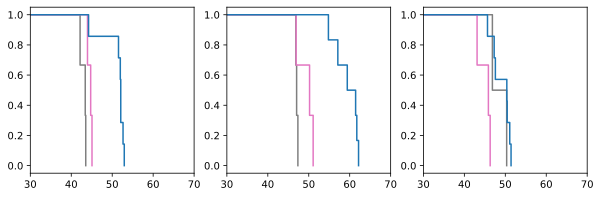

In [8]:
fig, axs = plt.subplots(figsize=(10, 3), ncols=3)
plot_survival([baseline_standalone_d2_h0_times, baseline_standalone_d0_h50_times, baseline_layered_d2_h50_times], axs[0], x_axis_low=30, x_axis_high=70)
plot_survival([dfs_standalone_d2_h0_times, dfs_standalone_d0_h50_times, dfs_layered_d2_h50_times], axs[1], x_axis_low=30, x_axis_high=70)
plot_survival([bfs_standalone_d2_h0_times, bfs_standalone_d0_h50_times, bfs_layered_d2_h50_times], axs[2], x_axis_low=30, x_axis_high=70)
fig.savefig('./plots/layered_survival_equiLarge.svg', transparent=True)

In [9]:
# Baseline attacker
baseline_standalone_d2_h50 = ingest_experiment_results(path.join('data/Layered/EquifaxSmall/baseline_standalone_d2_h50'))
baseline_layered_d2_h50 = ingest_experiment_results(path.join('data/Layered/EquifaxSmall/baseline_layered_d2_h50'))

# DFS attacker
dfs_standalone_d2_h50 = ingest_experiment_results(path.join('data/Layered/EquifaxSmall/dfs_standalone_d2_h50'))
dfs_layered_d2_h50 = ingest_experiment_results(path.join('data/Layered/EquifaxSmall/dfs_layered_d2_h50'))

# BFS attacker
bfs_standalone_d2_h50 = ingest_experiment_results(path.join('data/Layered/EquifaxSmall/bfs_standalone_d2_h50'))
bfs_layered_d2_h50 = ingest_experiment_results(path.join('data/Layered/EquifaxSmall/bfs_layered_d2_h50'))

baseline_layered_d2_h50_times = get_data_exfiltration_times(baseline_layered_d2_h50, expected_files=10)
baseline_standalone_d2_h50_times = get_data_exfiltration_times(baseline_standalone_d2_h50, expected_files=10)

dfs_layered_d2_h50_times = get_data_exfiltration_times(dfs_layered_d2_h50, expected_files=10, timeout_time_min=90)
dfs_standalone_d2_h50_times = get_data_exfiltration_times(dfs_standalone_d2_h50, expected_files=10, timeout_time_min=90)

bfs_layered_d2_h50_times = get_data_exfiltration_times(bfs_layered_d2_h50, expected_files=10, timeout_time_min=90)
bfs_standalone_d2_h50_times = get_data_exfiltration_times(bfs_standalone_d2_h50, expected_files=10, timeout_time_min=90)

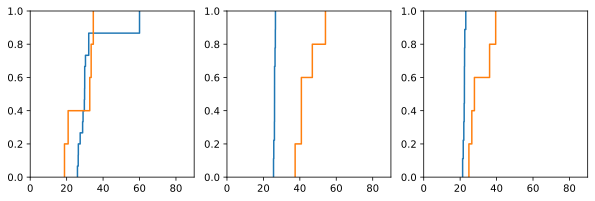

In [10]:
fig, axs = plt.subplots(figsize=(10, 3), ncols=3)
plot_ecdf([baseline_standalone_d2_h50_times, baseline_layered_d2_h50_times], axs[0], x_axis_low=0, x_axis_high=90)
plot_ecdf([dfs_standalone_d2_h50_times, dfs_layered_d2_h50_times], axs[1], x_axis_low=0, x_axis_high=90)
plot_ecdf([bfs_standalone_d2_h50_times, bfs_layered_d2_h50_times], axs[2], x_axis_low=0, x_axis_high=90)
fig.savefig('./plots/layered_survival_equiLarge.svg', transparent=True)

In [12]:
baseline_layered_d2_h50_times

,time_exfiltrated,survival,num_files
0,32.690440,1,12
1,33.455506,1,12
2,20.818399,1,12
3,18.810957,1,12
4,34.630464,1,12


In [11]:
baseline_standalone_d2_h50_times

,time_exfiltrated,survival,num_files
0,60.000000,0,0
1,29.903572,1,10
2,60.000000,0,0
3,29.011905,1,11
4,30.330039,1,10
5,28.767505,1,11
6,25.932633,1,11
7,29.912617,1,10
8,26.347554,1,11
9,32.117409,1,10


In [13]:
# Baseline attacker
baseline_standalone_d2_h50 = ingest_experiment_results(path.join('data/Layered/EquifaxLarge/baseline_standalone_d2_h50'))
baseline_layered_d2_h50 = ingest_experiment_results(path.join('data/Layered/EquifaxLarge/baseline_layered_d2_h50'))

# DFS attacker
dfs_standalone_d2_h50 = ingest_experiment_results(path.join('data/Layered/EquifaxLarge/dfs_standalone_d2_h50'))
dfs_layered_d2_h50 = ingest_experiment_results(path.join('data/Layered/EquifaxLarge/dfs_layered_d2_h50'))

# BFS attacker
bfs_standalone_d2_h50 = ingest_experiment_results(path.join('data/Layered/EquifaxLarge/bfs_standalone_d2_h50'))
bfs_layered_d2_h50 = ingest_experiment_results(path.join('data/Layered/EquifaxLarge/bfs_layered_d2_h50'))

baseline_layered_d2_h50_times = get_data_exfiltration_times(baseline_layered_d2_h50, expected_files=45)
baseline_standalone_d2_h50_times = get_data_exfiltration_times(baseline_standalone_d2_h50, expected_files=45)

dfs_layered_d2_h50_times = get_data_exfiltration_times(dfs_layered_d2_h50, expected_files=45, timeout_time_min=90)
dfs_standalone_d2_h50_times = get_data_exfiltration_times(dfs_standalone_d2_h50, expected_files=45, timeout_time_min=90)

bfs_layered_d2_h50_times = get_data_exfiltration_times(bfs_layered_d2_h50, expected_files=45, timeout_time_min=90)
bfs_standalone_d2_h50_times = get_data_exfiltration_times(bfs_standalone_d2_h50, expected_files=45, timeout_time_min=90)

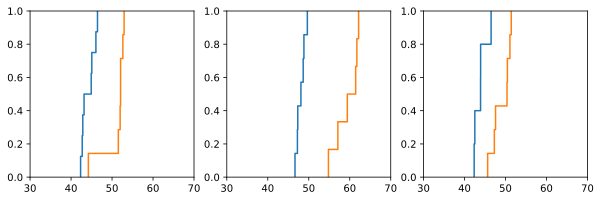

In [14]:
fig, axs = plt.subplots(figsize=(10, 3), ncols=3)
plot_ecdf([baseline_standalone_d2_h50_times, baseline_layered_d2_h50_times], axs[0], x_axis_low=30, x_axis_high=70)
plot_ecdf([dfs_standalone_d2_h50_times, dfs_layered_d2_h50_times], axs[1], x_axis_low=30, x_axis_high=70)
plot_ecdf([bfs_standalone_d2_h50_times, bfs_layered_d2_h50_times], axs[2], x_axis_low=30, x_axis_high=70)
fig.savefig('./plots/layered_survival_equiLarge.svg', transparent=True)

In [15]:
# Median data exfiltration times
baseline_standalone_d2_h50_median = baseline_standalone_d2_h0_times['time_exfiltrated'].median()
baseline_layered_d2_h50_median = baseline_layered_d2_h50_times['time_exfiltrated'].median()

dfs_standalone_d2_h50_median = dfs_standalone_d2_h0_times['time_exfiltrated'].median()
dfs_layered_d2_h50_median = dfs_layered_d2_h50_times['time_exfiltrated'].median()

bfs_standalone_d2_h50_median = bfs_standalone_d2_h0_times['time_exfiltrated'].median()
bfs_layered_d2_h50_median = bfs_layered_d2_h50_times['time_exfiltrated'].median()

print(f"Baseline Standalone D2 H50 Median: {baseline_standalone_d2_h50_median}")
print(f"Baseline Layered D2 H50 Median: {baseline_layered_d2_h50_median}")
print(f"Percent increase: {((baseline_layered_d2_h50_median - baseline_standalone_d2_h50_median) / baseline_standalone_d2_h50_median) * 100}%")

print(f"DFS Standalone D2 H50 Median: {dfs_standalone_d2_h50_median}")
print(f"DFS Layered D2 H50 Median: {dfs_layered_d2_h50_median}")
print(f"Percent increase: {((dfs_layered_d2_h50_median - dfs_standalone_d2_h50_median) / dfs_standalone_d2_h50_median) * 100}%")

print(f"BFS Standalone D2 H50 Median: {bfs_standalone_d2_h50_median}")
print(f"BFS Layered D2 H50 Median: {bfs_layered_d2_h50_median}")
print(f"Percent increase: {((bfs_layered_d2_h50_median - bfs_standalone_d2_h50_median) / bfs_standalone_d2_h50_median) * 100}%")

Baseline Standalone D2 H50 Median: 43.413758889834085
Baseline Layered D2 H50 Median: 52.08511334657669
Percent increase: 19.973747213980865%
DFS Standalone D2 H50 Median: 47.03738037347794
DFS Layered D2 H50 Median: 60.42674294312795
Percent increase: 28.465366190332347%
BFS Standalone D2 H50 Median: 48.59167982538541
BFS Layered D2 H50 Median: 50.372480102380116
Percent increase: 3.6648255079758996%
